# ****California Housing Prices (a linear regression versus a XGboost)****


In [2]:
#importing the libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### data collection

In [5]:
#loading the dataset and obtaining info about columns
df=pd.read_csv("california_housing.csv")

print(df)
print("*************")
print(df.columns)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  media

### Exploratory Data Analysis

In [3]:
#description of the numerical columns
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
#count the values of the columns
df.count()

longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
dtype: int64

## Preprocessing the data <a class="anchor" id="preprocessing"></a>

In [5]:
#We have missing values in the column total_bedrooms. We can drop the null rows or replace the null value for the mean.
#I choose to replace it with the mean
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)


C:\Users\hi\AppData\Local\Temp\ipykernel_21280\2106580144.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)


In [7]:
#I want information about the column "ocean_proximity"
df['ocean_proximity'].value_counts()


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
#Transform the variable into a numerical one.
def map_age(age):
    if age == '<1H OCEAN':
        return 0
    elif age == 'INLAND':
        return 1
    elif age == 'NEAR OCEAN':
        return 2
    elif age == 'NEAR BAY':
        return 3
    elif age == 'ISLAND':
        return 4
df['ocean_proximity'] = df['ocean_proximity'].apply(map_age)

<Axes: >

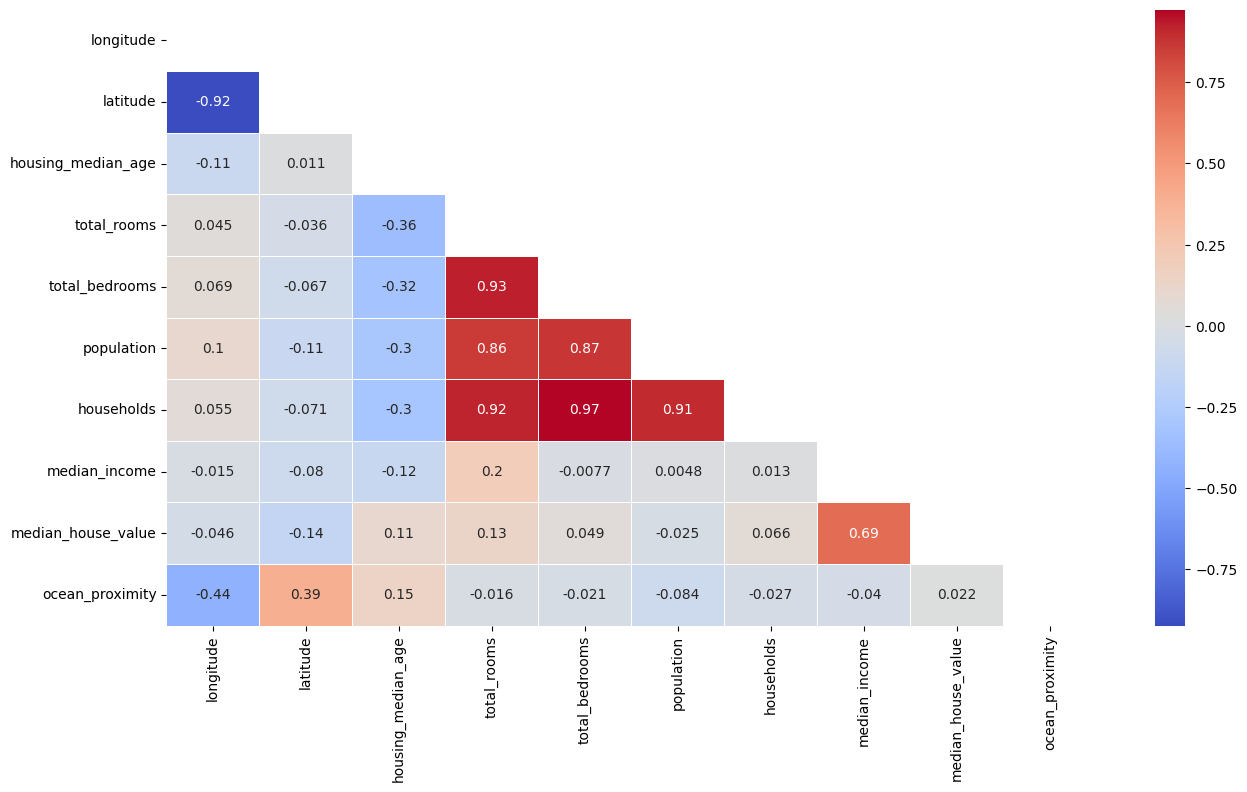

In [9]:
#Obtaining info of the correlations with a heatmap
plt.figure(figsize=(15,8))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), linewidths=.5,annot=True,mask=mask,cmap='coolwarm')


In [10]:
#There is a high correlation between households and population. So we drop household and keep population.
df.drop('households', axis=1, inplace=True)


In [11]:
# let's create 2 more columns with the total bedrooms and rooms per population in the same block.
df['average_rooms']=df['total_rooms']/df['population']
df['average_bedrooms']=df['total_bedrooms']/df['population']


In [12]:
#dropping the 2 columns we are not going to use
df.drop('total_rooms',axis=1,inplace=True)
df.drop('total_bedrooms',axis=1,inplace=True)

<Axes: >

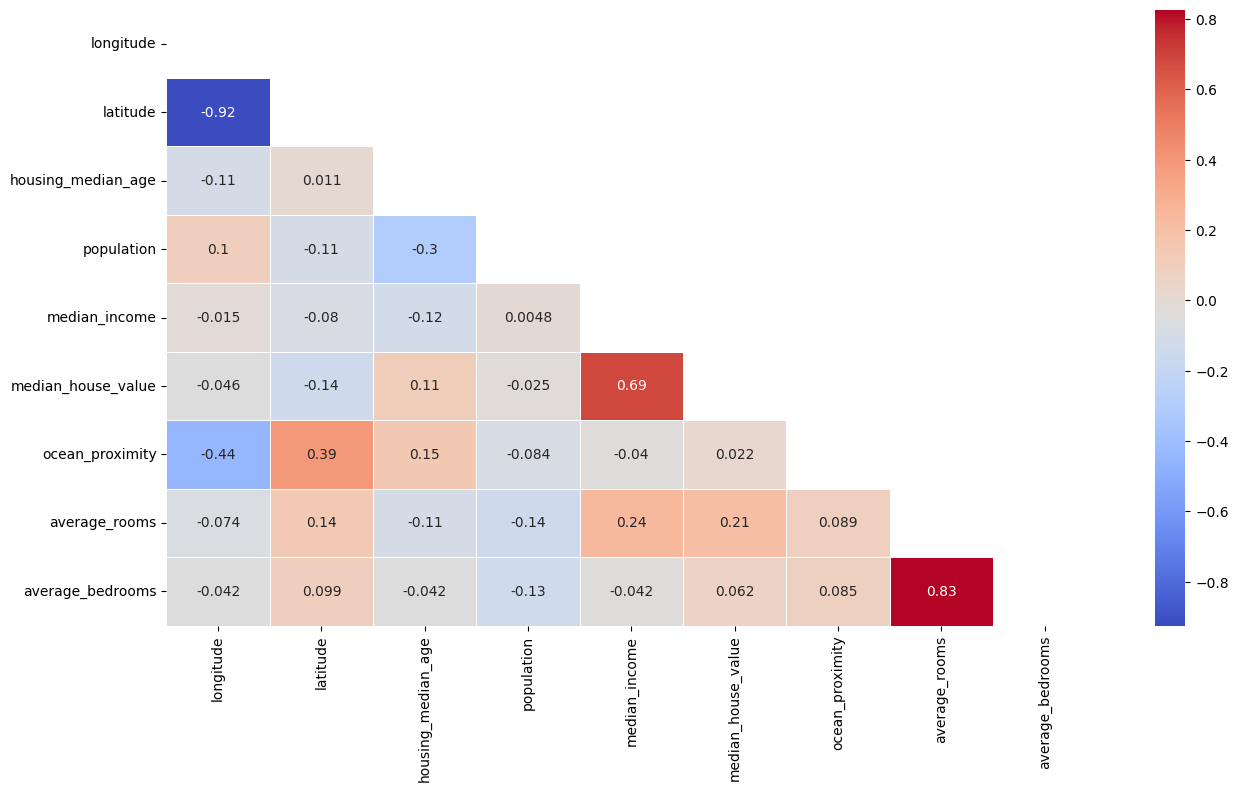

In [13]:
#Obtaining info of the new correlations with a heatmap
plt.figure(figsize=(15,8))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), linewidths=.5,annot=True,mask=mask,cmap='coolwarm')

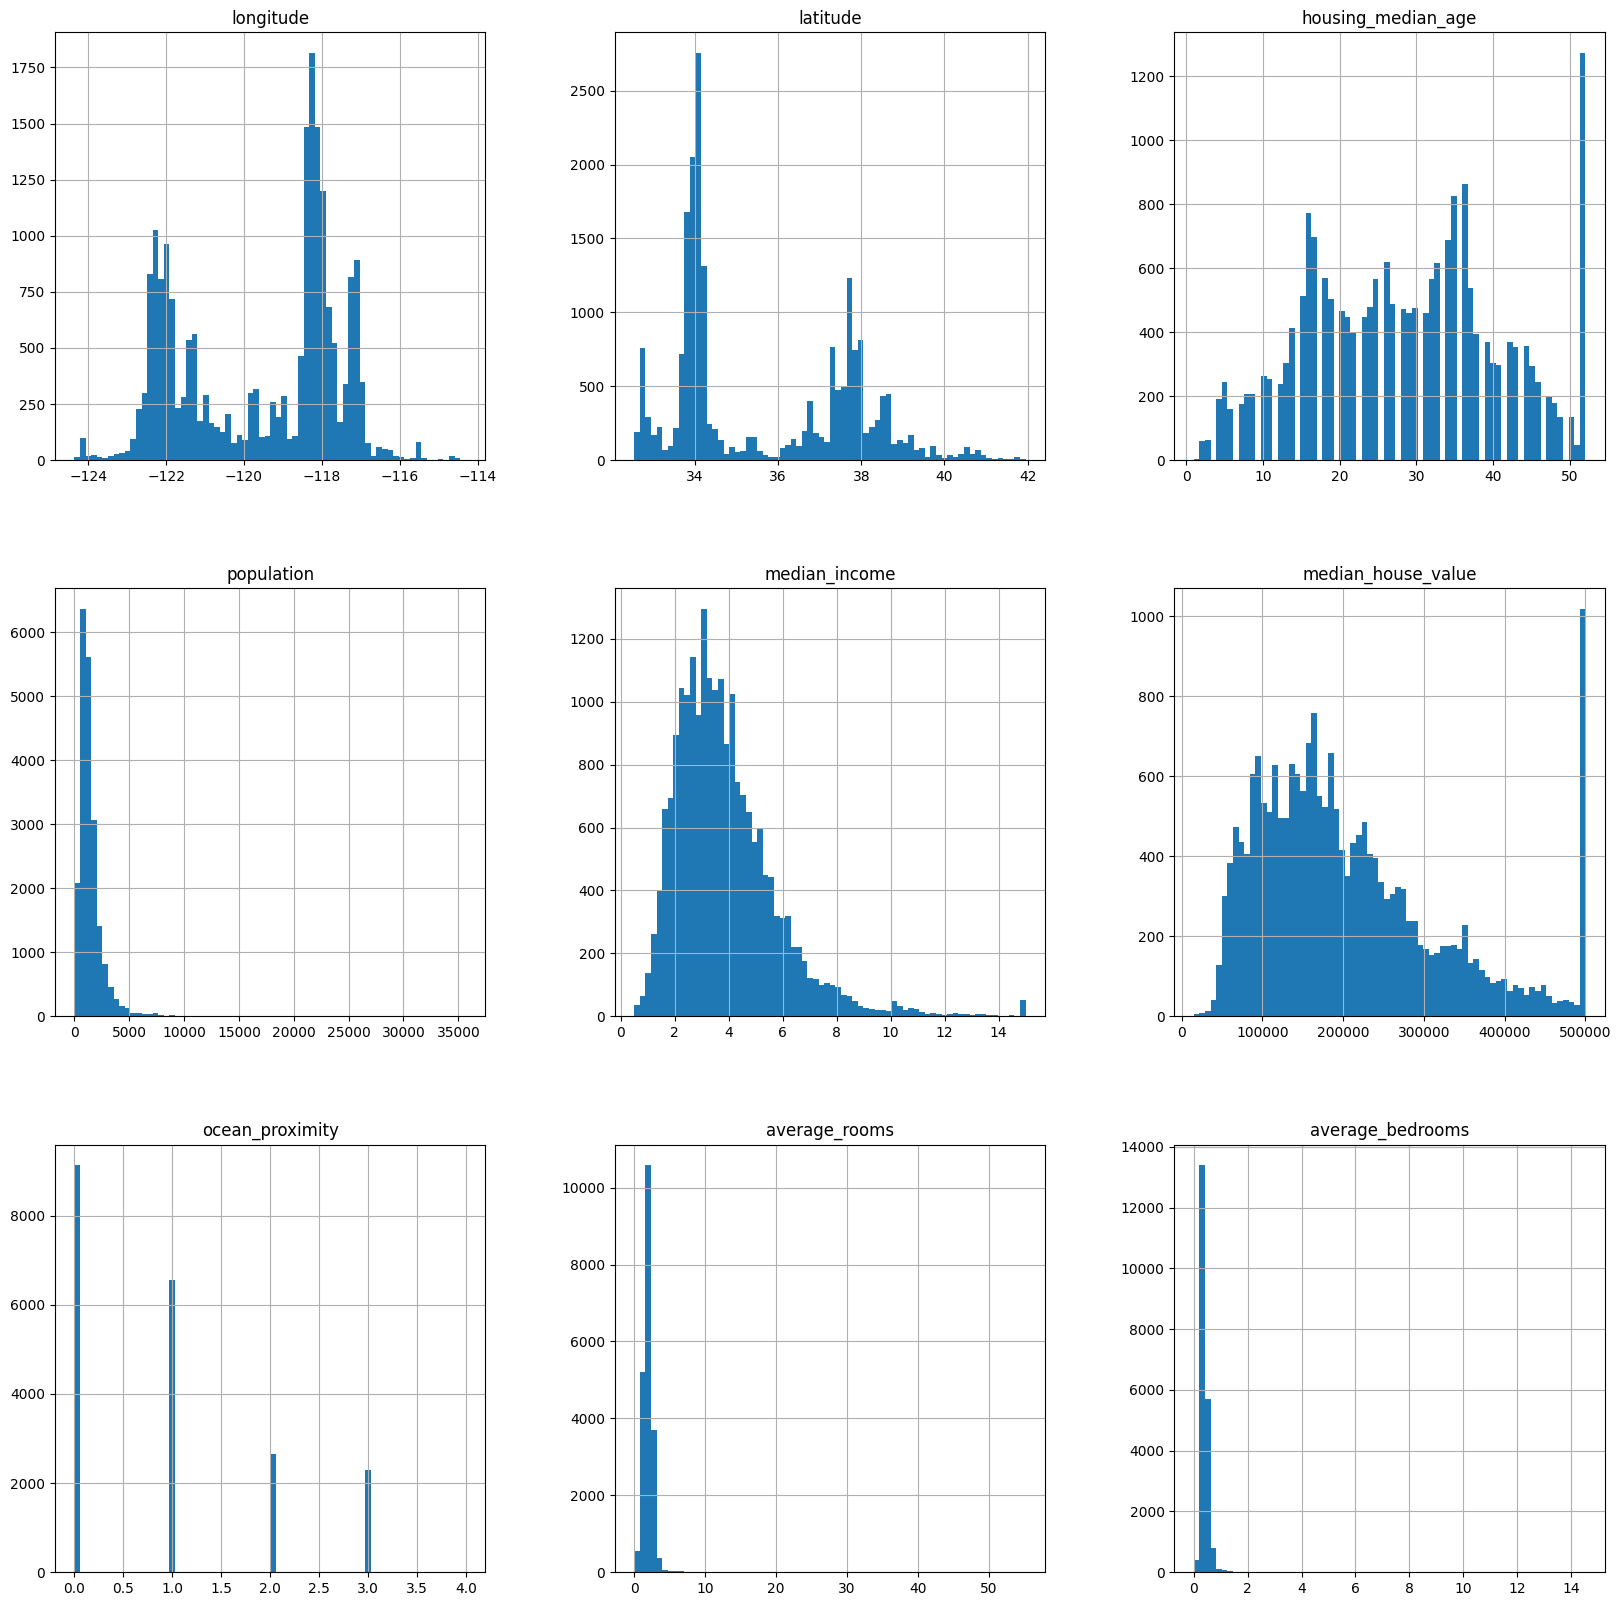

In [14]:
#histogram to get the distributions of the different variables
df.hist(bins=70, figsize=(20,20))
plt.show()

<Axes: xlabel='median_house_value'>

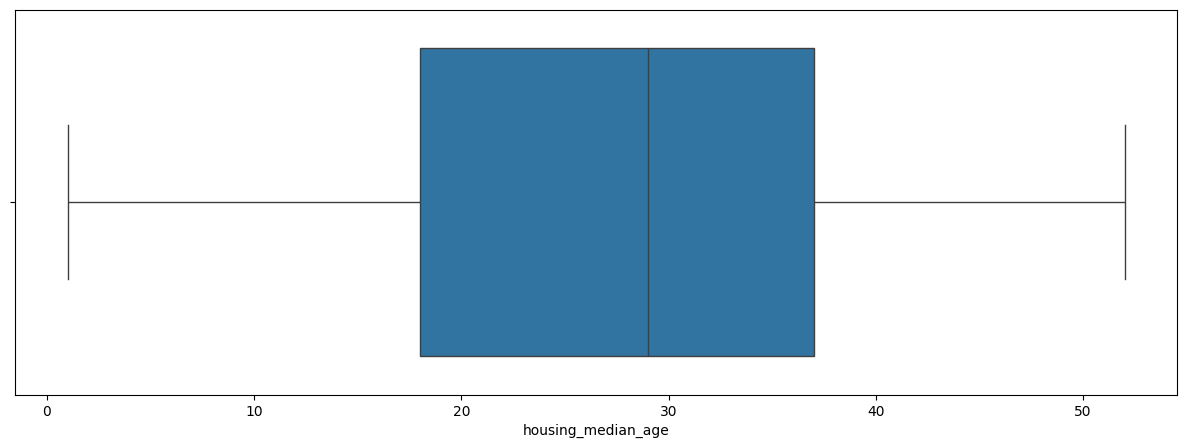

<Figure size 640x480 with 0 Axes>

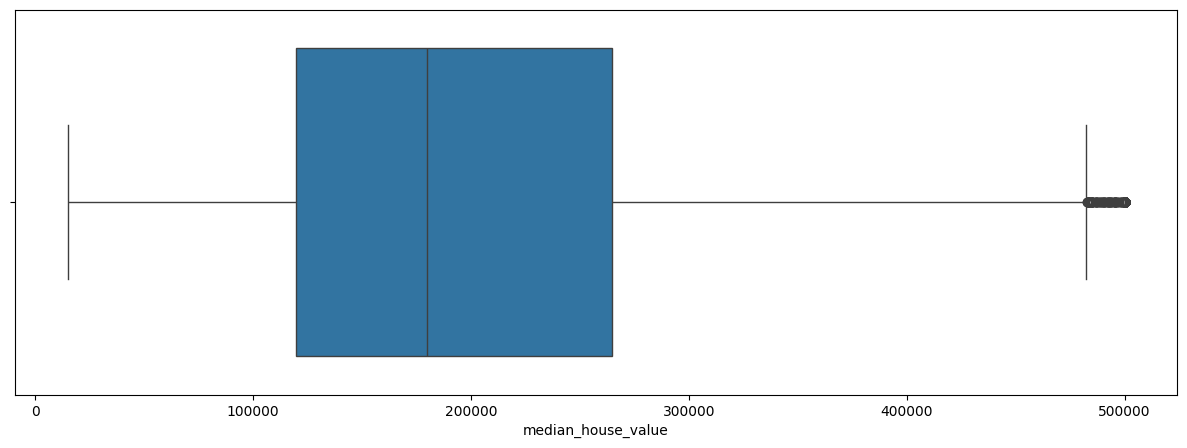

In [15]:
#Finding Outliers
plt.figure(figsize=(15,5))
sns.boxplot(x=df['housing_median_age'])
plt.figure()
plt.figure(figsize=(15,5))
sns.boxplot(x=df['median_house_value'])

In [16]:
#removing outliers
df=df.loc[df['median_house_value']<500001,:]

# Linear Regression <a class="anchor" id="Regression"></a>

## Training the model <a class="anchor" id="Training"></a>

In [17]:
#Choosing the dependant variable and the regressors. In this case we want to predict the housing price
X=df[['longitude',
 'latitude',
 'housing_median_age',
 'population',
 'median_income',
 'ocean_proximity',
 'average_rooms',
 'average_bedrooms']]
Y=df['median_house_value']

In [18]:
#splitting the dataset into the train set and the test set

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2, random_state=0)

In [19]:
#Training the model
from sklearn.linear_model import LinearRegression
regressor= LinearRegression()
regressor.fit(X_train,Y_train)

LinearRegression()

In [20]:
#Obtaining the predictions
y_pred = regressor.predict(X_test)


## Evaluating the model <a class="anchor" id="Evaluation"></a>

In [34]:
#R2 score
from sklearn.metrics import r2_score
r2=r2_score(Y_test,y_pred)
print('the R squared of the linear regression is:', r2)

the R squared of the linear regression is: 0.5526714001645368


       prediction    Actual
0   163735.595336  111400.0
1   247996.473247  194500.0
2   236026.307165  285400.0
3    57897.207706   64700.0
4    53982.094417   63000.0
5   157910.478923   96200.0
6   172983.025764  242200.0
7   195692.948093  119800.0
8   141901.026767  113900.0
9   247711.721817  380300.0
10  152515.742095  252300.0
11  210933.506842  120000.0
12  100406.923242  101900.0
13  163033.669449  134700.0
14  184811.750043  208700.0
15   38107.074304   84700.0
16  272841.956627  199300.0
17  253532.310905  209400.0
18  127508.923369  212500.0
19  149062.202129  244300.0
*****************


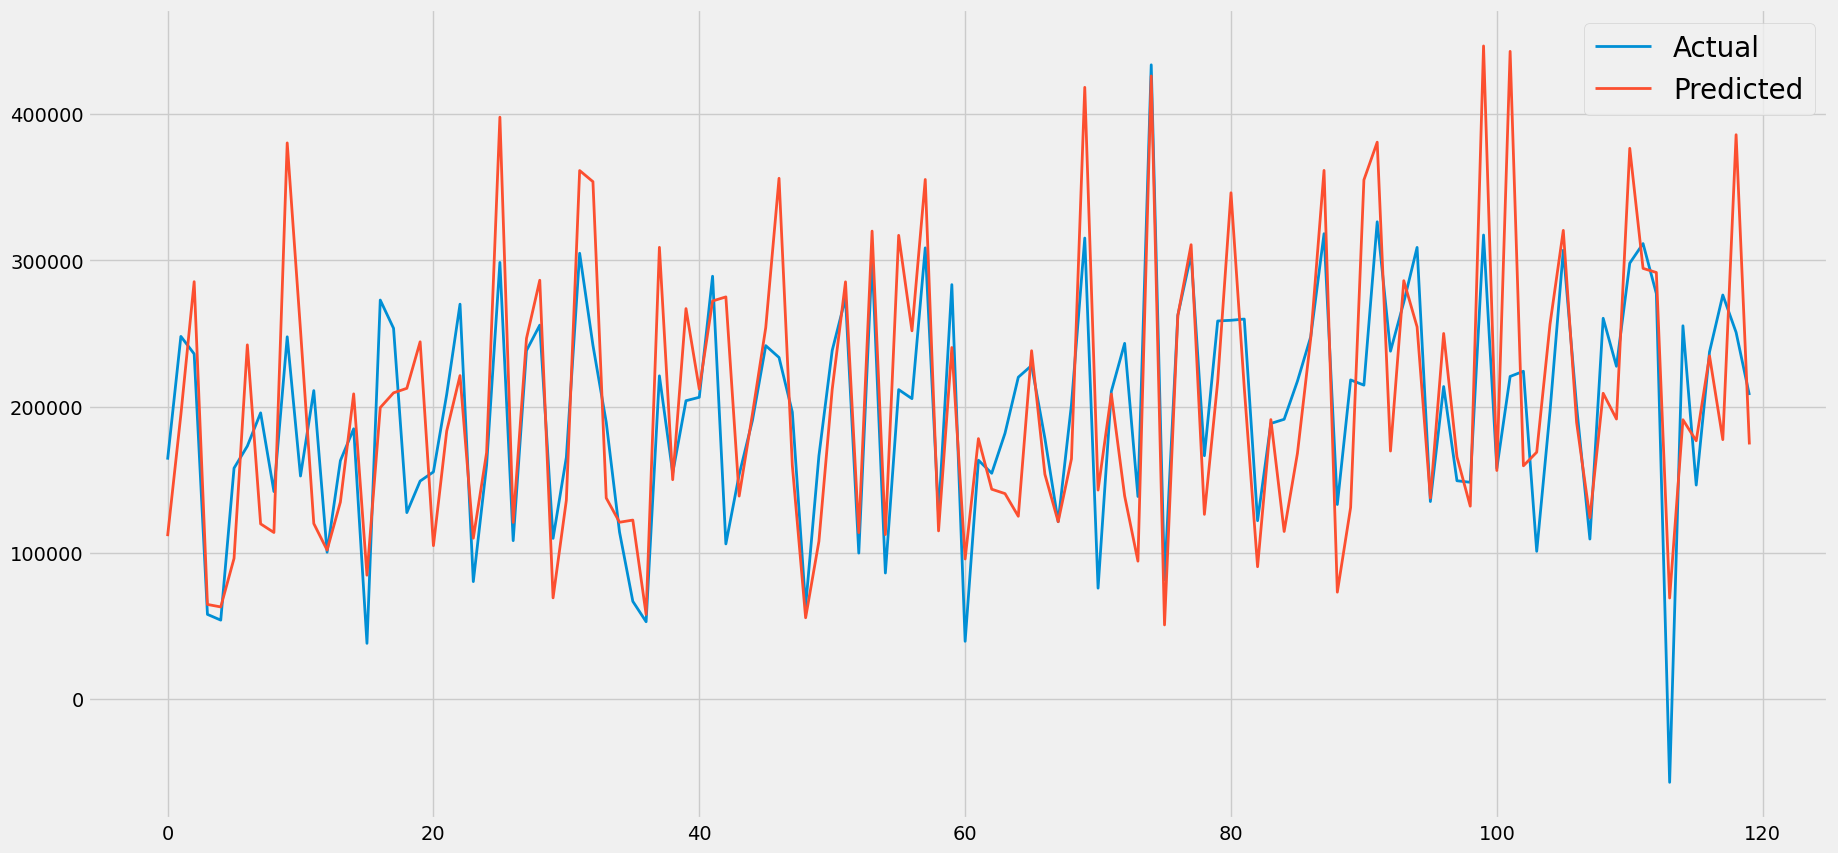

In [37]:
#Graphically, lets plot first 120 haouses predicted and actuual values
grp = pd.DataFrame({'prediction':y_pred,'Actual':Y_test})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
print(grp.head(20))
print("*****************")
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.plot(grp[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})

We see that actual and predicted are close but not very close.

# XGBoost <a class="anchor" id="Xgboost"></a>

## Training the model <a class="anchor" id="Training2"></a>

In [23]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:linear',
                          colsample_bytree = 1,
                          eta=0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          alpha = 10,
                          n_estimators = 2000)

In [24]:
xg_reg.fit(X_train,Y_train)

y_pred2 = xg_reg.predict(X_test)

c:\Users\hi\Desktop\projects\python_projects\tutorial\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


## Evaluating the model <a class="anchor" id="Evaluation2"></a>

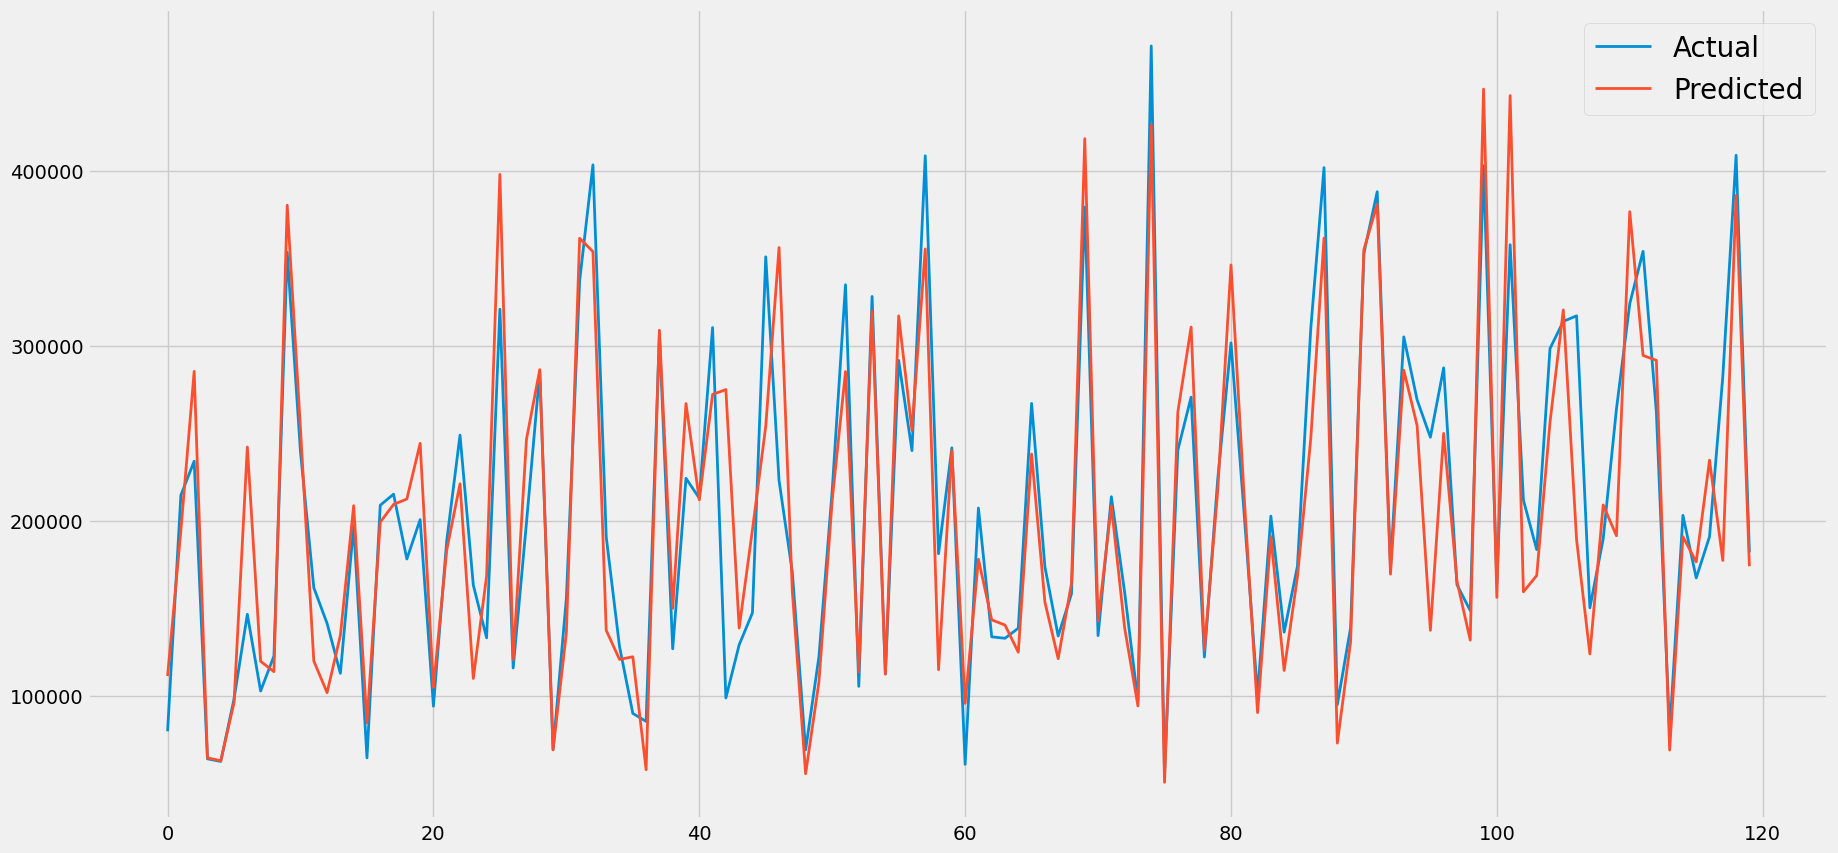

In [25]:
#Graphically
grp = pd.DataFrame({'prediction':y_pred2,'Actual':Y_test})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
plt.figure(figsize=(20,10))
plt.plot(grp[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})

Here we see that actual and predicted are more closer than the linear regression 

In [26]:
r2xgb=r2_score(Y_test,y_pred2)
print('the R squared of the xgboost method is:', r2xgb)

the R squared of the xgboost method is: 0.8237319084769034


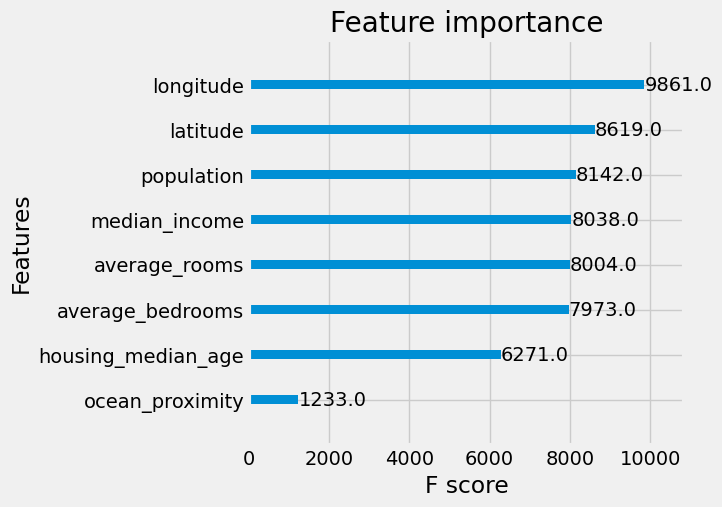

In [38]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [41]:
#Doing cross validation to see the accuracy of the XGboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
# kfold = KFold(n_splits=10, shuffle=False)
results = cross_val_score(regressor, X, Y, cv=kfold)
print("R square: %.2f%%, standard-deviation: (%.2f%%)" % (results.mean()*100, results.std()*100))

R square: 56.09%, standard-deviation: (6.01%)


- Model explains 56.09% of the variance in house prices.
- This is not great but not terrible either.
- In regression, anything above 70% is considered strong, while 40-70% is moderate.
- Since house prices depend on many external factors (like location, economy, etc.), it's normal for models to struggle reaching high accuracy.

This means your model’s accuracy fluctuates by ~6% across different folds.
- Low deviation (<5%) → The model is stable.
- Higher deviation (>10%) → The model is inconsistent across folds.
- Since your deviation is around 6%, it suggests some variations but still relatively stable.

# Linear regression vs XGBoost <a class="anchor" id="Comparison"></a>

In [33]:
#comparing the scores of both techniques 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

mae1 = mean_absolute_error(Y_test, y_pred)
rms1 = sqrt(mean_squared_error(Y_test, y_pred))
mae2 =mean_absolute_error(Y_test,y_pred2)
rms2 = sqrt(mean_squared_error(Y_test, y_pred2))

print('Stats for the linea regression: \n','mean squared error: ',rms1, '\n R2:',r2,' \n mean absolute error:',mae1 )
print('Stats xgboost: \n','mean squared error: ',rms2, '\n R2:',r2xgb,' \n mean absolute error:',mae2 )

Stats for the linea regression: 
 mean squared error:  65524.09768075902 
 R2: 0.5526714001645368  
 mean absolute error: 47427.66363813183
Stats xgboost: 
 mean squared error:  41131.50186202736 
 R2: 0.8237319084769034  
 mean absolute error: 27423.892853473437


### How to Improve Your Model?
1️. Feature Engineering

- Try scaling features (StandardScaler, MinMaxScaler from sklearn.preprocessing).
- Create new features (e.g., feature interactions, polynomial features).
- Check for correlation and remove redundant features.

2️. Hyperparameter Tuning

Optimize n_estimators, learning_rate, max_depth, subsample, colsample_bytree using GridSearchCV or RandomizedSearchCV.